In [4]:
from scipy.io import loadmat, savemat
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import vlkit.plt as vlplt
import pydicom
import os.path as osp
import time, sys
from utils import write_dicom, write_dicom_meta
import torch
import numpy as np
from pharmacokinetic import parker_aif, fit_slice, process_patient, get_ct_curve, np2torch
from tqdm import tqdm
from einops import rearrange
from models import Transformer

In [5]:
device = torch.device('cpu')
data = loadmat('../tmp/patient-0.mat')
data = np2torch(data)

t = (data['time_dce'] / 60).to(device=device)
aif_t = torch.arange(0, t[-1].item(), 1/60, dtype=torch.float64).to(t)

hct = 0.42
aif_cp = parker_aif(
    a1=0.809, a2=0.330,
    t1=0.17046, t2=0.365,
    sigma1=0.0563, sigma2=0.132,
    alpha=1.050, beta=0.1685, s=38.078, tau=0.483,
    t=aif_t - (t[int(data['maxBase'].item())-1] * 60).ceil() / 60
    ) / (1 - hct)

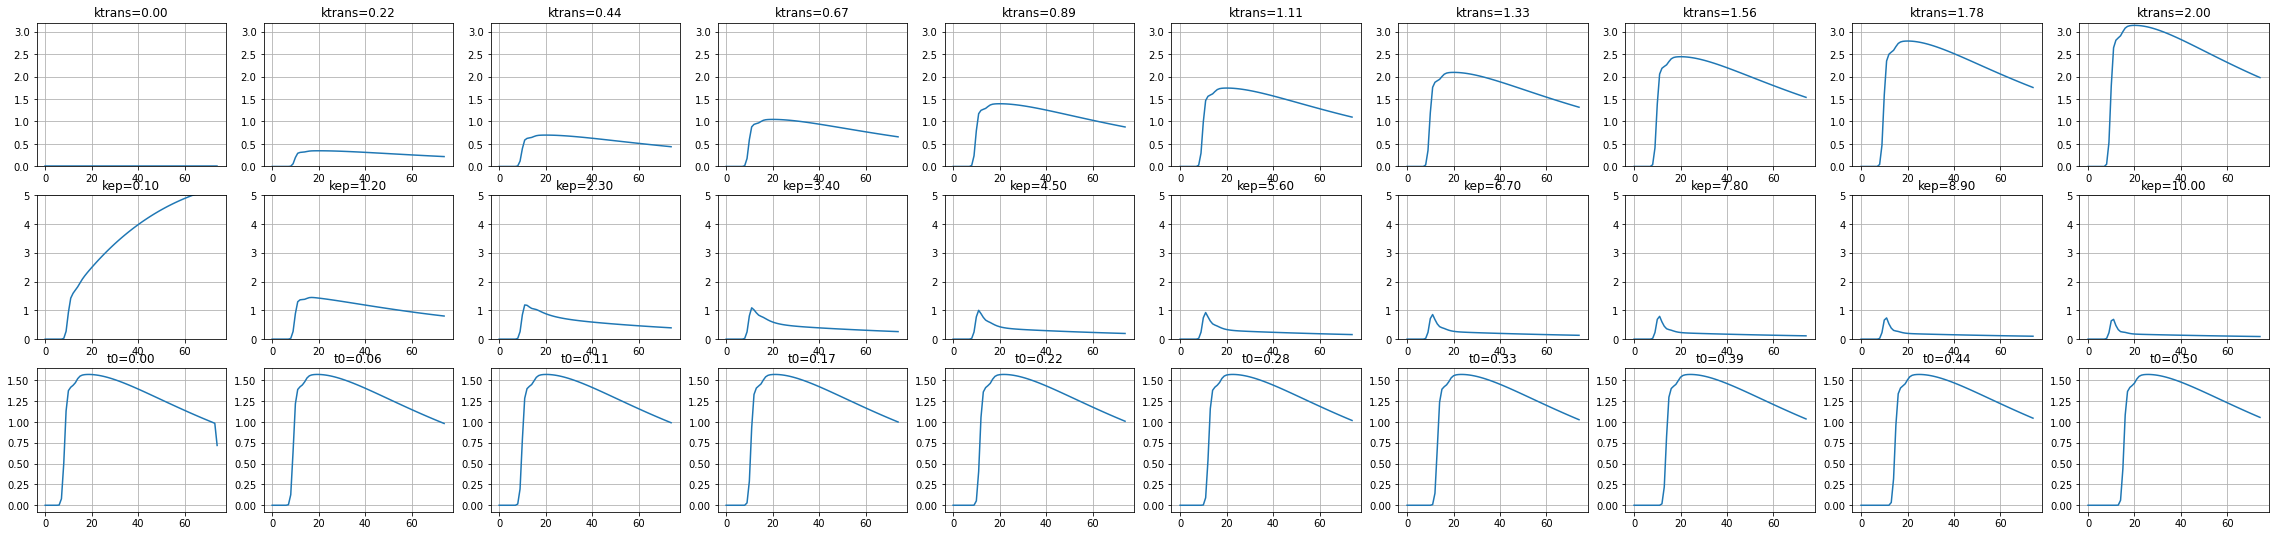

In [6]:
n = 10
fig, axes = plt.subplots(3, n, figsize=(n*4, 3*3))

# vlplt.clear_ticks(axes)


for idx, i in enumerate(np.linspace(0, 2, n)):
    curve = get_ct_curve(params=torch.tensor([i, 1, 0.1], dtype=torch.float), t=t, aif_t=aif_t, aif_cp=aif_cp)
    axes[0, idx].plot(curve)
    axes[0, idx].set_title('ktrans=%.2f' % i)
    axes[0, idx].grid(visible=True)
    axes[0, idx].set_ylim(0, 3.2)

for idx, i in enumerate(np.linspace(0.1, 10, n)):
    curve = get_ct_curve(params=torch.tensor([1, i, 0.1], dtype=torch.float), t=t, aif_t=aif_t, aif_cp=aif_cp)
    axes[1, idx].plot(curve)
    axes[1, idx].set_title('kep=%.2f' % i)
    axes[1, idx].grid(visible=True)
    axes[1, idx].set_ylim(0, 5)

for idx, i in enumerate(np.linspace(0, 0.5, n)):
    curve = get_ct_curve(params=torch.tensor([1, 1, i], dtype=torch.float), t=t, aif_t=aif_t, aif_cp=aif_cp)
    axes[2, idx].plot(curve)
    axes[2, idx].set_title('t0=%.2f' % i)
    axes[2, idx].grid(visible=True)
plt.savefig('curves-different-params.pdf')

In [7]:
model = Transformer(
        seq_len=75,
        drop_rate=0.2,
        use_grad=True,
        num_layers=3,
        num_heads=4,
        embed_dims=64
    )
model = model.to(torch.device('cuda'))
model.load_state_dict(torch.load('work_dirs/transformer-relu/model.pth'))

<All keys matched successfully>

In [8]:
matlab_kep = data['kep']
matlab_ktrans = data['ktrans']
matlab_t0 = data['t0']

ct = data['dce_ct'].to(torch.device('cuda')).float()


h, w, s, f = ct.shape
ct = rearrange(ct, 'h w s f -> h (w s) f').to(torch.device('cuda'))
torch_ktrans = torch.zeros(h, w*s).to(ct)
torch_kep = torch.zeros(h, w*s).to(ct)
torch_t0 = torch.zeros(h, w*s).to(ct)

tic = time.time()
with torch.no_grad():
    for i, d in enumerate(tqdm(ct)):
        ktrans_, kep_, t0_ = model(d.unsqueeze(dim=-1), t)
        torch_ktrans[i, ] = ktrans_.squeeze(dim=1)
        torch_kep[i, ] = kep_.squeeze(dim=1)
        torch_t0[i, ] = t0_.squeeze(dim=1)
ct = rearrange(ct, 'h (w s) f -> h w s f', w=w)


torch_ktrans = rearrange(torch_ktrans, 'h (w s) -> h w s', w=w)
torch_kep = rearrange(torch_kep, 'h (w s) -> h w s', w=w)
torch_t0 = rearrange(torch_t0, 'h (w s) -> h w s', w=w)

torch_ktrans = torch_ktrans.to(torch.device('cpu'))
torch_kep = torch_kep.to(torch.device('cpu'))
torch_t0 = torch_t0.to(torch.device('cpu'))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:13<00:00, 11.66it/s]


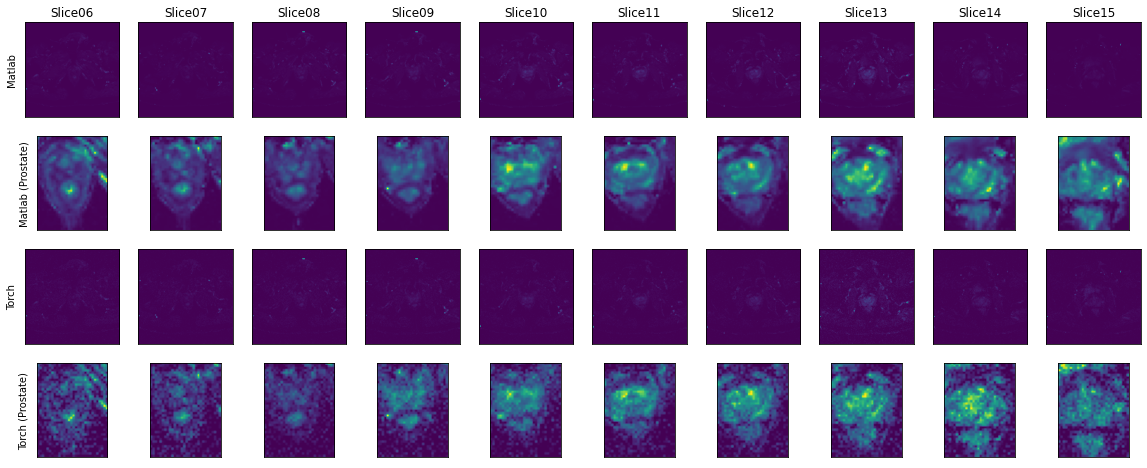

In [9]:
fig, axes = plt.subplots(4, 10, figsize=(20, 8))
vlplt.clear_ticks(axes)

for idx, i in enumerate(range(5, 15)):
    axes[0, idx].imshow(matlab_ktrans[:, :, i])
    axes[0, idx].set_title('Slice%.2d' % (i+1))
    if idx == 0:
        axes[0, idx].set_ylabel('Matlab')

    axes[1, idx].imshow(matlab_ktrans[70:110, 70:100, i])
    if idx == 0:
        axes[1, idx].set_ylabel('Matlab (Prostate)')
    #
    axes[2, idx].imshow(torch_ktrans[:, :, i])
    if idx == 0:
        axes[2, idx].set_ylabel('Torch')

    axes[3, idx].imshow(torch_ktrans[70:110, 70:100, i])
    if idx == 0:
        axes[3, idx].set_ylabel('Torch (Prostate)')
plt.savefig('ktrans.pdf')

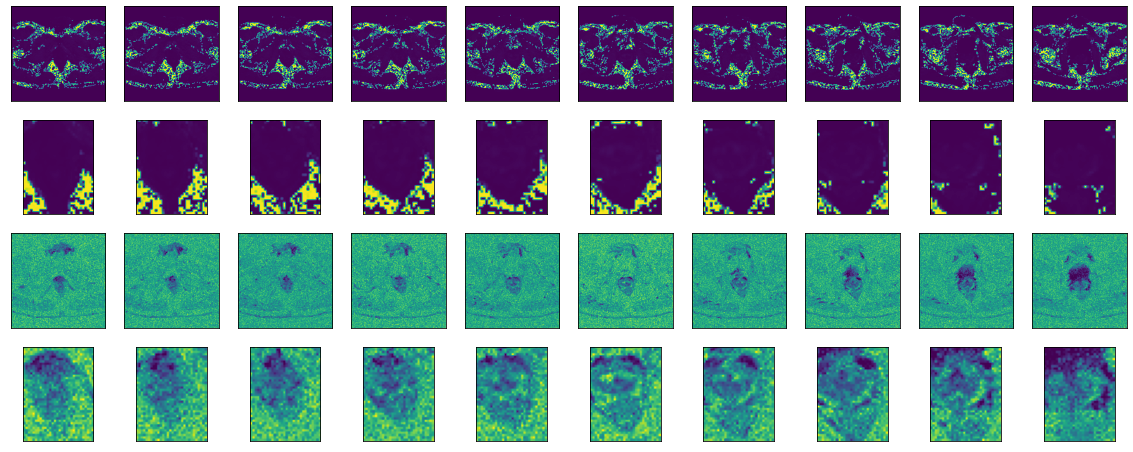

In [10]:
fig, axes = plt.subplots(4, 10, figsize=(20, 8))
vlplt.clear_ticks(axes)

for idx, i in enumerate(range(5, 15)):
    axes[0, idx].imshow(matlab_kep[:, :, i])
    axes[1, idx].imshow(matlab_kep[70:110, 70:100, i])
    #
    axes[2, idx].imshow(torch_kep[:, :, i])
    axes[3, idx].imshow(torch_kep[70:110, 70:100, i])
plt.savefig('kep.pdf')

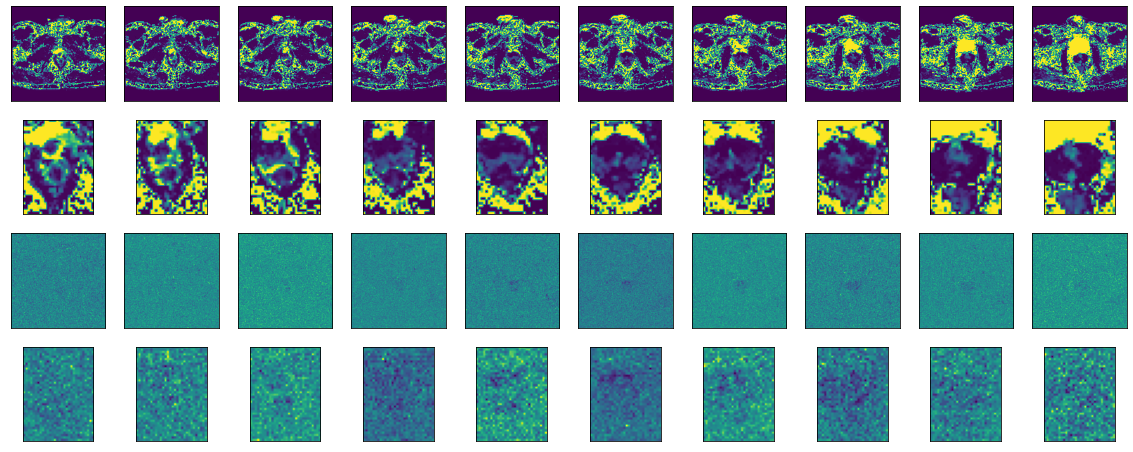

In [11]:
fig, axes = plt.subplots(4, 10, figsize=(20, 8))
vlplt.clear_ticks(axes)

for idx, i in enumerate(range(5, 15)):
    axes[0, idx].imshow(matlab_t0[:, :, i])
    axes[1, idx].imshow(matlab_t0[70:110, 70:100, i])
    #
    axes[2, idx].imshow(torch_t0[:, :, i])
    axes[3, idx].imshow(torch_t0[70:110, 70:100, i])
plt.savefig('t0.pdf')

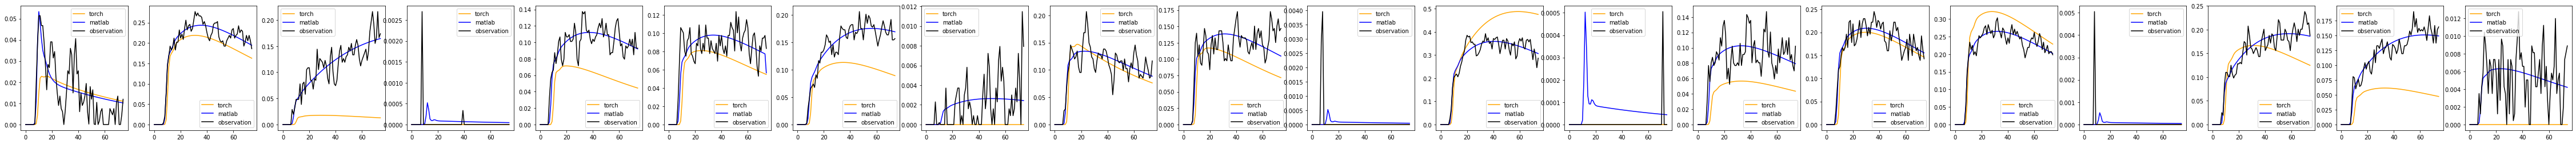

In [12]:
n = 20
ys = torch.randint(70, 110, size=(n,))
xs = torch.randint(70, 100, size=(n,))

torch_params = torch.cat((torch_ktrans[ys, xs, 10].view(1, -1), torch_kep[ys, xs, 10].view(1, -1), torch_t0[ys, xs, 10].view(1, -1)), dim=0).cpu()
matlab_params = torch.cat((matlab_ktrans[ys, xs, 10].view(1, -1), matlab_kep[ys, xs, 10].view(1, -1), matlab_t0[ys, xs, 10].view(1, -1)), dim=0).cpu()

fig, axes = plt.subplots(1, n, figsize=(n*4, 4))

for i in range(n):
    y, x = ys[i], xs[i]
    observation =  data['dce_ct'][y, x, 10, :]
    torch_curve = get_ct_curve(torch_params[:, i].flatten(), t=t, aif_t=aif_t.cpu(), aif_cp=aif_cp.cpu())
    matlab_curve = get_ct_curve(matlab_params[:, i].flatten(), t=t, aif_t=aif_t.cpu(), aif_cp=aif_cp.cpu())

    axes[i].plot(torch_curve, color='orange')
    axes[i].plot(matlab_curve, color='blue')
    axes[i].plot(observation, color='black')
    axes[i].legend(['torch', 'matlab', 'observation'])
    

## Improvements on top of previous code:

1. Sample parameters from Beta distribution instead of uniform distribution.
2. Narrow the range of kep (from 0-50 to 0-5).


Text(0.5, 1.0, 't0')

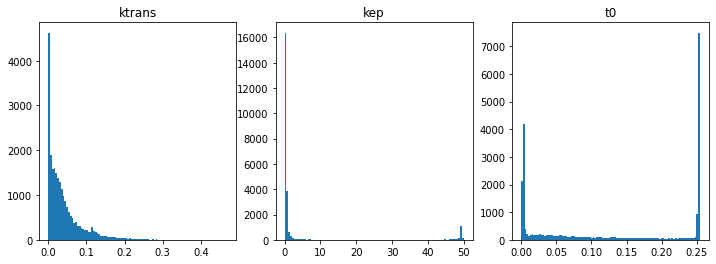

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(data['ktrans'][70:110, 70:100,].flatten(), 100)
axes[0].set_title('ktrans')

axes[1].hist(data['kep'][70:110, 70:100,].flatten(), 100)
axes[1].set_title('kep')

axes[2].hist(data['t0'][70:110, 70:100,].flatten(), 100)
axes[2].set_title('t0')